Using TensorFlow backend.


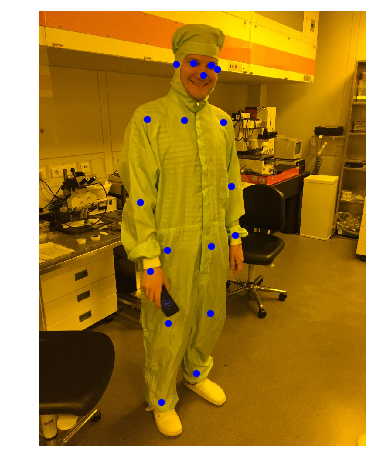

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import cv2
import numpy as np
sys.path.append('.')

from poseestimation import model

# --- load image ---
img_path = './julian.JPG'
I = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)


# -------------------------
pe = model.PoseEstimator()
positions = pe.predict(I)
# -------------------------


# --- plotting ---

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.imshow(I)
ax.axis('off')

for img_pos in positions[0]: # for all entities in the image
    for x,y in np.squeeze(img_pos):
        ax.scatter(y,x, color='blue')

plt.show()